# Triage Model Validation

This notebook outlines the procedure used for training and validating the model used for predicting patient arrivals.

DISCLAIMER:
The data used below is artificial data generated to closely resemble the real data. 
This data is used for illustative purposes as the validation results on the real data must be kept private to protect patient data.

### Assumptions
The following assumptions are made as part of the modeling process: 
1. The book date is the same day the patient is first known (arrival)
2. The method of inferring triage classes is accurate (this assumption only exists until data with triage classes is available)

The validity of these assumptions affects the accuracy of the model and validation results.

## Data Analysis

In [29]:
import triage_ml
import resources as sim

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from datetime import datetime, timedelta
from collections import defaultdict, deque
from tensorflow import keras
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, HTML, Image

DATA_DIR = 'sample_data'

RAW_DATA_FILE_NAME = f'{DATA_DIR}/raw_data.csv'
PROCESSED_DATA_FILE_NAME = f'{DATA_DIR}/data.csv'
CLINICS_FILE_NAME = f'{DATA_DIR}/clinics.txt'

with open(CLINICS_FILE_NAME) as clinics_file:
    CLINICS = [c.strip() for c in clinics_file.readlines()]

TRIAGE_CLASSES = [
    ('Urgent', 2, 0.95),
    ('Semi-Urgent', 12, 0.8),
    ('Standard', 23, 0.5),
    ('Low-Urgency', 52, 0.5),
    ('Other', 1000, 0.5)
]

# Used for inferring triage classes in historical data
TRIAGE_CLASS_DURATION_MUTLTIPLIER = 2

In [3]:
with open(RAW_DATA_FILE_NAME) as raw_data:
    total_arrivals = [line.split(',') for line in raw_data.readlines()[1:]]
    
arrivals = defaultdict(list)
for arrival in total_arrivals:
    arrivals[arrival[1]].append({
        'status': arrival[2],
        'date_received': datetime.strptime(arrival[4], '%d/%m/%y'),
        'date_seen': datetime.strptime(arrival[5].rstrip(), '%d/%m/%y')
   })
    
clinics = list(arrivals.keys())

print(f'Total arrivals: {len(total_arrivals)}')
print('Arrivals per clinic:')
for clinic in arrivals.keys():
    sorted(arrivals[clinic], key=lambda arr: arr['date_received'])
    print(f'  {clinic}: {len(arrivals[clinic])}')

Total arrivals: 4155
Arrivals per clinic:
  CLINIC: 4155


### Add triage classes

In [4]:
# We double each threshold to reflect the inefficiency of the current clinic
severity_thresholds = [2*7*tc[1] for tc in TRIAGE_CLASSES]

def get_severity(arrival_date, seen_date):
    days = (seen_date - arrival_date).days
    for i, val in enumerate(severity_thresholds):
        if days < val:
            return i

severities = [tc[0] for tc in TRIAGE_CLASSES]
clinic_datasets = {}
severities_table = dict({'Severities': severities}, **{clinic: [0 for s in severities] for clinic in arrivals.keys()})
for clinic in arrivals.keys():
    data = []
    for arrival in arrivals[clinic]:
        arrival['severity'] = get_severity(arrival['date_received'], arrival['date_seen'])
        severities_table[clinic][arrival['severity']] += 1
        data.append((clinics.index(clinic), arrival['severity'], arrival['date_received']))
    clinic_datasets[clinic] = triage_ml.data.dataset.DataSet(data)
    clinic_datasets[clinic].order_by('date_received')

display(pd.DataFrame(severities_table))

,Severities,CLINIC
0,Urgent,1330
1,Semi-Urgent,2392
2,Standard,399
3,Low-Urgency,34
4,Other,0


We now have the following variables:
* **clinics**: A list of clinic names
* **arrivals**: A dict of per-clinic arrivals
* **clinic_datasets**: A dict of clinic data as a Triage DataSets

### Data Visualizations

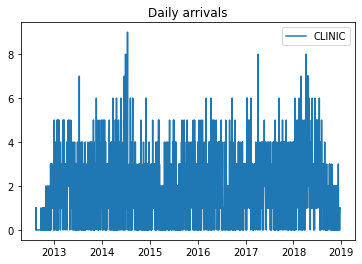

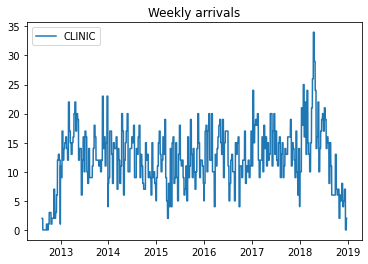

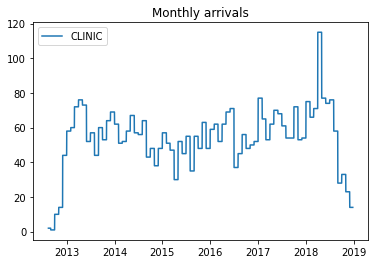

In [5]:
def date_range(min_date: datetime, max_date: datetime):
    for n in range(int((max_date - min_date).days) + 1):
        yield min_date + timedelta(n)

day_agg, day_fn = {}, lambda d: str(d.date())
week_agg, week_fn = {}, lambda d: datetime.strftime(d, '%Y-%U')
month_agg, month_fn = {}, lambda d: datetime.strftime(d, '%Y-%m')
for clinic, dataset in clinic_datasets.items():
    day_agg[clinic] = dataset.aggregate_on('date_received', day_fn)
    week_agg[clinic] = dataset.aggregate_on('date_received', week_fn)
    month_agg[clinic] = dataset.aggregate_on('date_received', month_fn)

# Day
for clinic, dataset in clinic_datasets.items():
    first, last = dataset[0].date_received, dataset[-1].date_received
    x = list(date_range(first, last))
    y = [
        len(day_agg[clinic][day_fn(date)])
            if day_fn(date) in day_agg[clinic] 
            else 0
            for date in x
        ]
    plt.plot(x, y, label=clinic)
plt.title('Daily arrivals')
plt.legend()
plt.show()

# Week
for clinic, dataset in clinic_datasets.items():
    first, last = dataset[0].date_received, dataset[-1].date_received
    x = list(date_range(first, last))
    y = [
        len(week_agg[clinic][week_fn(date)])
            if week_fn(date) in week_agg[clinic] 
            else 0
            for date in x
        ]
    plt.plot(x, y, label=clinic)
plt.title('Weekly arrivals')
plt.legend()
plt.show()

# Month
for clinic, dataset in clinic_datasets.items():
    first, last = dataset[0].date_received, dataset[-1].date_received
    x = list(date_range(first, last))
    y = [
        len(month_agg[clinic][month_fn(date)])
            if month_fn(date) in month_agg[clinic] 
            else 0
            for date in x
        ]
    plt.plot(x, y, label=clinic)
plt.title('Monthly arrivals')
plt.legend()
plt.show()

### Dataset properties

In [6]:
total_arrivals = []
for clinic in CLINICS:
    total_arrivals += arrivals[clinic]

for arrival in total_arrivals:
    data.append((0, arrival['severity'], arrival['date_received']))
    
dataset = triage_ml.data.dataset.DataSet(data)
dataset.order_by('date_received')

dayofweek_agg = dataset.aggregate_on('date_received', lambda dr: datetime.strftime(dr, '%A'))
for dayofweek, arrivals in dayofweek_agg.items():
    print(f'{dayofweek}: {len(arrivals)}')

Friday: 1208
Monday: 1174
Saturday: 1092
Sunday: 1162
Thursday: 1238
Tuesday: 1170
Wednesday: 1266


### Save dataset

In [7]:
dataset.write_to_file(PROCESSED_DATA_FILE_NAME)

## Training

The Radius Variance model is trained for the 4 triage classes using the preset:
* radius in weeks: 15
* sequence length in weeks: 30

On slower computers, expect up to 5 minutes to train each class.

In [58]:
train_tc0 = f'triage-train -m radius_variance -c 0 -s 0 -e 500 -lr 0.01 -d {PROCESSED_DATA_FILE_NAME} -w {DATA_DIR + "/tc0-weights.h5"} -r {DATA_DIR + "/tc0-results.png"} > {DATA_DIR}/tc0-logs.txt'
!$train_tc0

2021-03-29 13:19:10.592354: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-03-29 13:19:13.507385: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-29 13:19:13.508191: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-03-29 13:19:13.527387: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-29 13:19:13.530522: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-KKNEBOQ
2021-03-29 13:19:13.530878: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-KKNEBOQ
2021-03-29 13:19:13.531597: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Libr

In [60]:
train_tc1 = f'triage-train -m radius_variance -c 0 -s 1 -e 500 -lr 0.01 -d {PROCESSED_DATA_FILE_NAME} -w {DATA_DIR + "/tc1-weights.h5"} -r {DATA_DIR + "/tc1-results.png"} > {DATA_DIR}/tc1-logs.txt'
!$train_tc1

2021-03-29 13:20:32.536933: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-03-29 13:20:35.375366: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-29 13:20:35.376030: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-03-29 13:20:35.394461: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-29 13:20:35.397391: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-KKNEBOQ
2021-03-29 13:20:35.397708: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-KKNEBOQ
2021-03-29 13:20:35.398330: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Libr

In [61]:
train_tc2 = f'triage-train -m radius_variance -c 0 -s 2 -e 500 -lr 0.01 -d {PROCESSED_DATA_FILE_NAME} -w {DATA_DIR + "/tc2-weights.h5"} -r {DATA_DIR + "/tc2-results.png"} > {DATA_DIR}/tc2-logs.txt'
!$train_tc2

2021-03-29 13:21:38.257553: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-03-29 13:21:41.552082: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-29 13:21:41.553145: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library nvcuda.dll
2021-03-29 13:21:41.576877: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-29 13:21:41.579824: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-KKNEBOQ
2021-03-29 13:21:41.580133: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-KKNEBOQ
2021-03-29 13:21:41.580662: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Libr

### Training Results

TC: Urgent


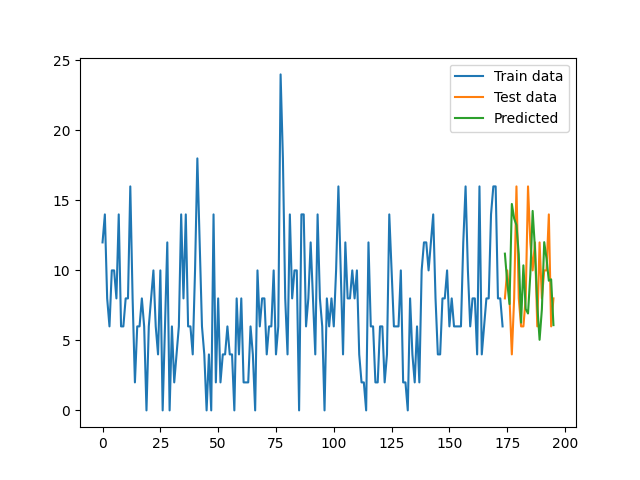

TC: Semi-Urgent


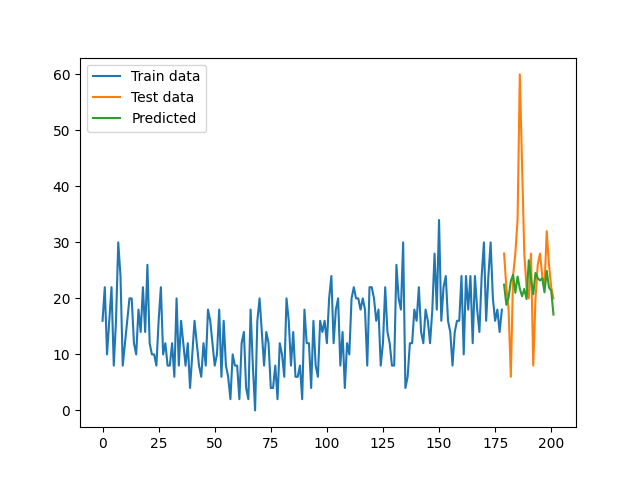

TC: Standard


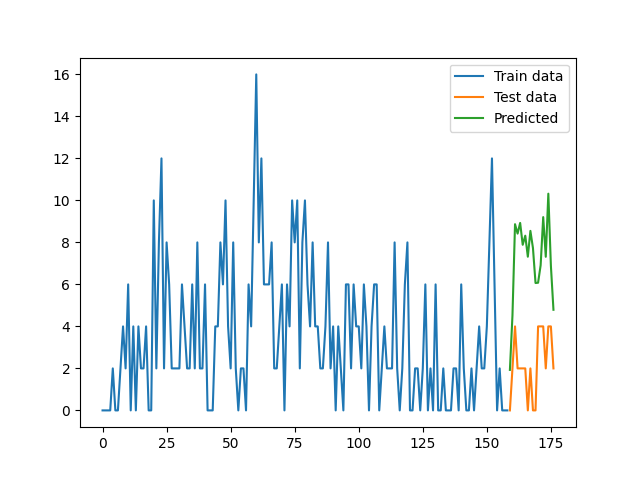

In [62]:
for i in range(len(TRIAGE_CLASSES)):
    file_path = f'{DATA_DIR}/tc{i}-results.png'
    if os.path.isfile(file_path):
        print(f'TC: {TRIAGE_CLASSES[i][0]}')
        display(Image(filename=file_path))

The above graphs illustrate the mean of the arrivals the model predicts, however the model also predicts the variance of arrivals. The graphs below illustrate that be displaying the standard deviation as error bars.

## Model Validation

In [65]:
def load_dataset_from_file(file_name):
    data = []
    with open(file_name) as f:
        for line in f.readlines():
            line = line.rstrip().split(',')
            data.append((
                int(line[0]),
                int(line[1]),
                datetime.strptime(line[2], '%Y-%m-%d'),
            ))

    return triage_ml.data.dataset.DataSet(data)

def gen_next_date(date_encoding, days=7):
    month = np.argmax(date_encoding[:12]) + 1
    day = np.argmax(date_encoding[12:]) + 1
    date = datetime.strptime(f'2000/{0 if month < 10 else ""}{month}/{0 if day < 10 else ""}{day}', '%Y/%m/%d')
    date = date + timedelta(days=days)
    
    one_hot_date = np.zeros(12 + 31)
    one_hot_date[date.date().month] = 1
    one_hot_date[11 + date.date().day] = 1
    
    return one_hot_date

class DataFrame:
    def __init__(self, intervals, predictions):
        self.intervals = intervals
        self.predictions = predictions

    def get_interval_size(self, interval):
        # Check validity of input interval index.
        if interval not in range(0, len(self.intervals)):
            raise ValueError("Invalid interval %s.", interval)

        # Return the length of a given interval
        return self.intervals[interval][1] - self.intervals[interval][0] + 1
    
    def get_interval_sample(self, interval):
        # Check validity of input interval index.
        if interval not in range(0, len(self.intervals)):
            raise ValueError("Invalid interval %s.", interval)
        
        # Get start and end of interval
        start = self.intervals[interval][0]
        end = self.intervals[interval][1]+1
        
        # Generate and return sample
        res = [round(max(0, np.random.normal(p[0], math.sqrt(p[1])))) for p in self.predictions[start:end]]
        return res
    
def plot_sim(confidence, prev_weeks=52, weeks=104, interval_length=4):
    for severity, (tc_name, window, min_ratio) in enumerate(TRIAGE_CLASSES):
        if not os.path.isfile(f'{DATA_DIR}/tc{severity}-weights.h5'):
            continue

        dataset = load_dataset_from_file(PROCESSED_DATA_FILE_NAME)
        dataset.filter_on('severity', lambda s: s == severity)

        model = triage_ml.models.radius_variance.RadiusVariance(seq_size=30, radius=15, time_interval=triage_ml.data.dataset.TimeInterval.WEEK)
        ml_dataset = model.create_ml_dataset(dataset)
        train_dataset, test_dataset = ml_dataset.split(0.8)

        data = np.append(train_dataset.outputs[0][-prev_weeks:], test_dataset.outputs[0], axis=0)
        data = [(d[0], 0) for d in data]
        true_dataframe = DataFrame([(i, i+interval_length-1) for i in range(0, prev_weeks, interval_length)], data)

        true_results = sim.gen_min_interval_slots(queue=deque(), 
                                                  data_frame=true_dataframe, 
                                                  start=1, 
                                                  end=prev_weeks // interval_length - 1,
                                                  min_ratio=min_ratio, 
                                                  window=window, 
                                                  final_window=2*window, 
                                                  confidence=confidence,
                                                  num_sim_runs=1)

        model._init_model()
        model.model.load_weights(f'{DATA_DIR}/tc{severity}-weights.h5')

        dates = list(test_dataset.inputs[1])
        for i in range(weeks):
            dates.append(gen_next_date(dates[-1]))
        dates = np.stack(dates)

        preds = model.predict([x[np.newaxis, -1] for x in train_dataset.inputs[-30:]], dates)
        preds = [np.array(p)[0] for p in preds]
        data = np.append(train_dataset.outputs[0][-4:], preds, axis=0)
        data = [(d[0], math.sqrt(d[1])) for d in data]

        pred_dataframe = DataFrame([(i, i+interval_length-1) for i in range(0, weeks, interval_length)], data)

        pred_results = sim.gen_min_interval_slots(queue=deque(), 
                                                  data_frame=pred_dataframe, 
                                                  start=1, 
                                                  end=weeks // interval_length - 1,
                                                  min_ratio=min_ratio, 
                                                  window=window, 
                                                  final_window=2*window, 
                                                  confidence=confidence,
                                                  num_sim_runs=100)

        true_y = [res.expected_slots for res in true_results]
        true_ave = len(true_y)*[np.mean(true_y)]
        pred_y = [res.expected_slots for res in pred_results]
        pred_ave = len(pred_y)*[np.mean(pred_y)]
        arrivals = [sum(data[i:i+interval_length][0])/interval_length for i in range(0, interval_length*len(pred_y), interval_length)]
        arrivals_err = [sum(data[i:i+interval_length][1])/interval_length for i in range(0, interval_length*len(pred_y), interval_length)]
        # print(true_y, pred_y, arrivals)
        plt.plot(range(len(true_y)), true_y, ',-k', label='Actual slots required')
        plt.plot(range(len(true_y)), true_ave, ',:k')
        plt.plot([i + (prev_weeks // interval_length) - interval_length for i in range(len(pred_y))], pred_y, ',-b', label='Predicted slots required')
        plt.plot([i + (prev_weeks // interval_length) - interval_length for i in range(len(pred_y))], pred_ave, ',:b')
        plt.errorbar([i + (prev_weeks // interval_length) - interval_length for i in range(len(pred_y))], arrivals, yerr=arrivals_err, label='Predicted arrivals', elinewidth=1, fmt=',-c')  
        plt.title(f'TC: {tc_name}')
        plt.legend()
        plt.show()

The following uses the results of training to run a simulation and predict the number of slots required by the clinic.
We use a confidence of 90% which means that in 90% of simulated runs, the returned slots are sufficient to see the required patients.

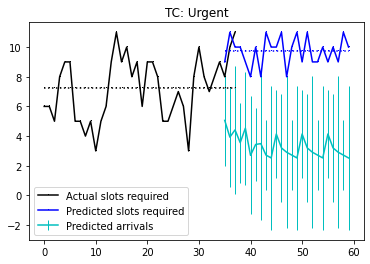

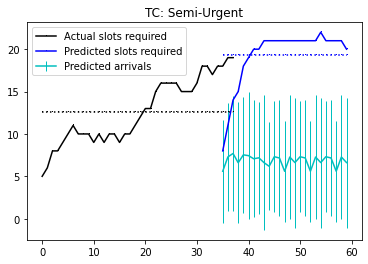

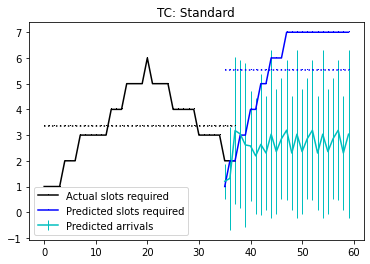

In [66]:
plot_sim(confidence=90, prev_weeks=156)

### Observations

* The predicted average slots required are higher than the actual slots required. This is because the simulation considers the variation in the predictions, the slots required needs to be higher to compensate for the uncertainty. 
* There is a fairly high standard deviation predicted by the model. It's better to error on the side of caution here, so the high variance is not much of a concern.
* The predicted slots required have a sensible mean but the raw values increase over time in a way that is likely not ideal for clinic schedules. This is because, (1) the simulation solves an optimization problem and thus minimizes slots and, (2) the patients not required to be seen within `window` must eventually be seen within `final_window`, thus increasing the number of slots required later.

### Future Improvements
* Continue to collect data that includes real triage classes. Once sufficient data is collected, verify that the inferred triage class assumption holds
* Consider using a filter on the results provided by the simulation. For example, smoothing the predicted slots by only ever increasing the number of cumulative slots at every date.

